In [1]:
import seapy
import Obs_workspace as ow
import numpy as np
import matplotlib.pyplot as plt

NumExpr defaulting to 8 threads.


In [2]:
grdfile = '/Volumes/TO_1/outputs_SCORRECTION/ocean_ecs_fwd_15461_outer1.nc'
dt = 1/24/60
grid = seapy.model.asgrid(grdfile)

In [3]:
# add kodc obs
import datetime
ctd_file = '/Volumes/TO_1/roms4dvar_ecs/i4dvar_outputs/INSITU_OBS/KODC_YS.txt'
ctd_id = open(ctd_file)

ctd_id.readline()

line= ctd_id.readlines()

line = [iline.split('\t') for iline in line]

iline = 0
irecord = 1
for crt_line in line:
    if iline == 0:
        kodc_record = [irecord,]
        kodc_line = [float(crt_line[1]),]
        kodc_station = [float(crt_line[2]),]
        kodc_time = (datetime.datetime.strptime(crt_line[3],'%Y-%m-%d %H:%M')-
                     datetime.timedelta(hours=9) - 
                    datetime.datetime(1970,1,1)).total_seconds()/3600/24
        # print('KST:',crt_line[3])
        # print('UTC:',kodc_time,(datetime.timedelta(days=kodc_time)+datetime.datetime(1970,1,1)).strftime('%Y-%m-%d %H:%M',))
        kodc_lat = float(crt_line[4])
        kodc_lon = float(crt_line[5])
        kodc_depth = float(crt_line[7])
        kodc_temp = float(crt_line[8])
        kodc_tqc = float(crt_line[9])
        kodc_salt = float(crt_line[10])
        kodc_sqc = float(crt_line[11])
        
    else:
        if kodc_line[-1] != float(crt_line[1]): irecord+=1
        kodc_record = np.r_[kodc_record,irecord]
        kodc_line = np.r_[kodc_line,float(crt_line[1])]
        kodc_station = np.r_[kodc_station,float(crt_line[2])]
        kodc_time = np.r_[kodc_time, (datetime.datetime.strptime(crt_line[3],'%Y-%m-%d %H:%M')-
                                      datetime.timedelta(hours=9) - 
                                      datetime.datetime(1970,1,1)).total_seconds()/3600/24]
        # print('KST:',crt_line[3])
        # print('UTC:',kodc_time[-1],(datetime.timedelta(days=kodc_time[-1])+datetime.datetime(1970,1,1)).strftime('%Y-%m-%d %H:%M',))
        kodc_lat = np.r_[kodc_lat,float(crt_line[4])]
        kodc_lon = np.r_[kodc_lon,float(crt_line[5])]
        kodc_depth = np.r_[kodc_depth, float(crt_line[7])]
        kodc_temp = np.r_[kodc_temp, float(crt_line[8])]
        kodc_tqc = np.r_[kodc_tqc,float(crt_line[9])]
        kodc_salt = np.r_[kodc_salt, float(crt_line[10])]
        kodc_sqc = np.r_[kodc_sqc,float(crt_line[11])]
        
        
    iline+=1
ctd_id.close()
for iline in [107.,106.,105.,104.,103.,102.,209.,208.,207.]:
    exclude_pos = np.where(kodc_line != iline)
    kodc_record = kodc_record[exclude_pos]
    kodc_station = kodc_station[exclude_pos]
    kodc_time = kodc_time[exclude_pos]
    kodc_lat = kodc_lat[exclude_pos]
    kodc_lon = kodc_lon[exclude_pos]
    kodc_depth = kodc_depth[exclude_pos]
    kodc_temp = kodc_temp[exclude_pos]
    kodc_tqc = kodc_tqc[exclude_pos]
    kodc_salt = kodc_salt[exclude_pos]
    kodc_sqc = kodc_sqc[exclude_pos]
    kodc_line =kodc_line[exclude_pos]

In [4]:
data = [seapy.roms.obs.raw_data("TEMP", "CTD", kodc_temp,None,0.1),
                seapy.roms.obs.raw_data("SALT", "CTD", kodc_salt,None,0.01),]
kodc_obs = seapy.roms.obs.gridder_ctd(grid,kodc_time,
                                                kodc_lon,kodc_lat,-kodc_depth, 
                                                data,dt,title="CTD observation KODC")

Output()

In [5]:
#load sst_with cruise
withcruise_obs = seapy.roms.obs.obs(filename='/Volumes/TO_1/roms4dvar_ecs/i4dvar_outputs/INSITU_OBS/sst_withcruise_2012.nc')
# withcruise_obs = seapy.roms.obs.obs(filename='/Volumes/TO_1/roms4dvar_ecs/i4dvar_outputs/NOAA_GHRSST/geopolar_sst_201304nc')
withcruise_obs_org = withcruise_obs.copy()
# merge with sst_with cruise
withcruise_obs.add(kodc_obs)

In [6]:
# super observation
merge_obs = seapy.roms.obs.gridder_s(grid,withcruise_obs,dt)
merge_obs.to_netcdf('/Volumes/TO_1/roms4dvar_ecs/i4dvar_outputs/INSITU_OBS/sst_withcruisepkodc_2012.nc')

Output()

In [39]:
thistime = np.where(withcruise_obs_org.time==15812.5)

In [41]:
withcruise_obs.provenance[thistime]

(45510,)

In [8]:
final_obs = seapy.roms.obs.obs(filename='/Volumes/TO_1/roms4dvar_ecs/i4dvar_outputs/INSITU_OBS/sst_withcruisepkodc_2012.nc')

In [25]:
thisyppe = np.where(final_obs.type==6)

In [10]:
thisdepth = np.where(final_obs.depth[thisyppe ]==0)

In [42]:
np.unique(final_obs.provenance[thisyppe][thisdepth])

masked_array(data=[200, 355],
             mask=False,
       fill_value=999999,
            dtype=int32)

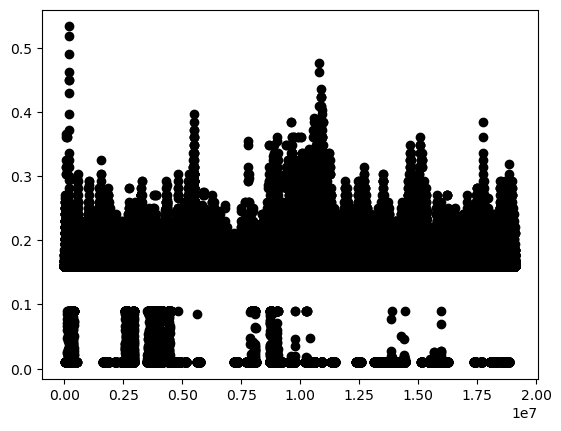

In [26]:
plt.plot(final_obs.error[thisyppe],'ko')

In [16]:
final_obs.error[final_obs.provenance==277]

masked_array(data=[0.085],
             mask=False,
       fill_value=1e+20)

In [17]:
final_obs.time[final_obs.provenance==277]

masked_array(data=[15584.5],
             mask=False,
       fill_value=1e+20)

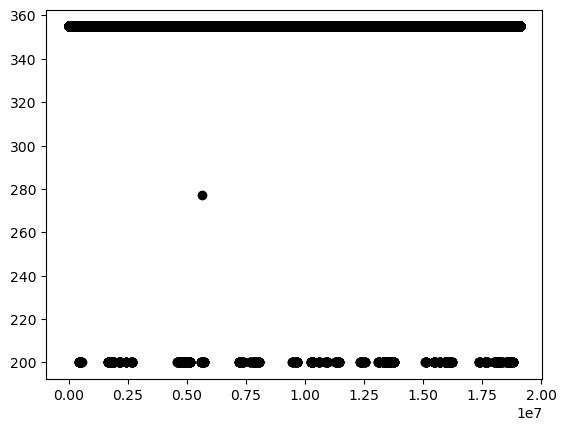

In [20]:
plt.plot(final_obs.provenance[thisyppe][thisdepth],'ko')

In [12]:
print(np.unique(kodc_obs.time))

[15469.91666667 15469.98958333 15470.04791667 15470.12152778
 15470.18263889 15470.25       15470.31180556 15470.38055556
 15470.48333333 15470.53958333 15470.71527778 15470.84375
 15470.95       15471.0125     15471.09444444 15471.16944444
 15471.25138889 15471.33125    15471.43194444 15471.54027778
 15471.66805556 15471.84166667 15471.90555556 15471.975
 15472.04513889 15472.12361111 15472.18888889 15472.25763889
 15472.325      15472.3875     15472.49097222 15472.58888889
 15497.07013889 15497.13888889 15497.18194444 15497.22916667
 15497.27430556 15497.31944444 15497.36458333 15497.40833333
 15497.54166667 15497.58333333 15497.62777778 15497.67013889
 15497.71180556 15497.75347222 15497.79166667 15497.875
 15497.91666667 15497.96180556 15499.09375    15499.14236111
 15499.18402778 15499.22777778 15499.27222222 15499.31597222
 15499.35763889 15499.39930556 15499.44097222 15499.48263889
 15499.59027778 15499.63333333 15499.68055556 15499.72569444
 15499.77083333 15499.8125     15499.

In [21]:
for i, itime in enumerate(kodc_obs.time[kodc_obs.depth ==0]):
    if itime in withcruise_obs_org.time:
        print(itime)

15584.5
15584.5
15812.5
15812.5
15849.5
15849.5
